# KAN UNET encoder

In [105]:
from kan import KAN

In [106]:
from kan_convolutional.KANConv import KAN_Convolutional_Layer

In [107]:
import torch
from torch import nn
import torch.nn.functional as F

In [149]:
class UNET_KAN_encoder(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        
        self.KANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters, #changed from in channels to this
            kernel_size = (3,3),
            padding = (1,1),
        )

        
        self.KANconv_2 = KAN_Convolutional_Layer(
            n_convs = num_filters, #changed from num_filters to 1
            kernel_size = (3,3),
            padding = (1,1),
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride = 2,
        )

    def forward(self, x):
        x = self.KANconv_1(x)
        x = self.KANconv_2(x)
        
        x = self.pool1(x)

        return x

In [150]:
class UNET_KAN_decoder(nn.Module):
    def __init__(self, num_filters, in_channels, out_channels, skip_features):
        super().__init__()
        self.DKANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters, #changed to 1 from num_filters
            kernel_size = (3,3),
            padding = (0,0),
        )

        self.ReduceChannels = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1)
        
        self.DKANconv_2 = KAN_Convolutional_Layer(
            n_convs = num_filters,
            kernel_size = (3,3),
            padding = (0,0),
        )
    def forward(self, x, skip_features):
        #Increase image size
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #Make skip features match dimensions of upscaled input
        if skip_features != None:
            skip_features = nn.functional.interpolate(skip_features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True)
    
            x = torch.cat((x, skip_features), dim=1)

        x = self.DKANconv_1(x)
        x = self.DKANconv_2(x)
        x = self.ReduceChannels(x)

        return x

In [151]:
class KAN_UNET(nn.Module):
    def __init__(self, input_shape=(3,256,256), num_classes=1, in_channels=1, out_channels=1):
        super().__init__()

        self.encoder1 = UNET_KAN_encoder(num_filters = 3)
        self.encoder2 = UNET_KAN_encoder(num_filters = 3)
        self.encoder3 = UNET_KAN_encoder(num_filters = 2)
        self.encoder4 = UNET_KAN_encoder(num_filters = 1)
        
        self.bottleneck_KAN_conv1 = KAN_Convolutional_Layer(
            n_convs = 1, #changed from 1024 to 1
            kernel_size = (3,3),
            padding=(0,0)
        )
        self.bottleneck_KAN_conv2 = KAN_Convolutional_Layer(
            n_convs = 1, #changed from 1024 to 1
            kernel_size = (3,3),
            padding=(0,0)
        )

        self.decoder1 = UNET_KAN_decoder(num_filters = 1, in_channels = 1944, out_channels = 512, skip_features=None)
        self.decoder2 = UNET_KAN_decoder(num_filters = 2, in_channels = 5936, out_channels = 256, skip_features=None)
        self.decoder3 = UNET_KAN_decoder(num_filters = 2, in_channels = 1996, out_channels = 128, skip_features=None)
        self.decoder4 = UNET_KAN_decoder(num_filters = 3, in_channels = 1395, out_channels = num_classes, skip_features=None)
        self.decoder5 = UNET_KAN_decoder(num_filters = 5, in_channels = 25, out_channels = num_classes, skip_features=None)

        self.output_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.output_conv= KAN_Convolutional_Layer(
        #     n_convs = num_classes,
        #     kernel_size = (1,1),
        #     padding=(0,0)
        # )

    def forward(self, x):
        print(f"Input Shape: {x.shape}")
        s1 = self.encoder1(x)
        print(f"Shape s1: {s1.shape}")
        s2 = self.encoder2(s1)
        print(f"Shape s2: {s2.shape}")
        s3 = self.encoder3(s2)
        print(f"Shape s3: {s3.shape}")
        s4 = self.encoder4(s3)
        print(f"Shape s4: {s4.shape}")

        b1 = self.bottleneck_KAN_conv1(s4)
        print(f"Shape b1: {b1.shape}")
        b2 = self.bottleneck_KAN_conv2(b1)
        print(f"Shape b2: {b2.shape}")

        d1 = self.decoder1(b2, s4)
        print(f"Shape d1: {d1.shape}")
        d2 = self.decoder2(d1, s3)
        print(f"Shape d2: {d2.shape}")
        d3 = self.decoder3(d2, s2)
        print(f"Shape d3: {d3.shape}")
        d4 = self.decoder4(d3, s1)
        print(f"Shape d4: {d4.shape}")
        d5 = self.decoder5(d4, skip_features=None)
        print(f"Shape d5: {d5.shape}")

        outputs = self.output_conv(d5)
        print(f"Output Shape: {outputs.shape}")
        return outputs, s4

In [201]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path, input_shape):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(input_shape[1:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

modelnotrain = KAN_UNET(input_shape=(3, 256, 256), num_classes=1, out_channels=3)
modelnotrain.eval()


image_path = '/Users/haziq/Downloads/cat-(3).png'
input_tensor = load_image(image_path, input_shape=(3, 256, 256))

In [287]:
with torch.no_grad():
    outputnotrain, s4_1 = modelnotrain(input_tensor)

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 27, 128, 128])
Shape s2: torch.Size([1, 243, 64, 64])
Shape s3: torch.Size([1, 972, 32, 32])
Shape s4: torch.Size([1, 972, 16, 16])
Shape b1: torch.Size([1, 972, 14, 14])
Shape b2: torch.Size([1, 972, 12, 12])
Shape d1: torch.Size([1, 512, 20, 20])
Shape d2: torch.Size([1, 256, 36, 36])
Shape d3: torch.Size([1, 128, 68, 68])
Shape d4: torch.Size([1, 1, 132, 132])
Shape d5: torch.Size([1, 1, 260, 260])
Output Shape: torch.Size([1, 3, 260, 260])


In [288]:
output_imagenotrain = outputnotrain.squeeze(0).detach()

In [289]:
output_imagenotrain.shape

torch.Size([3, 260, 260])

In [290]:
output_imagenotrain = output_imagenotrain.numpy()
output_imagenotrain.shape

(3, 260, 260)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.0959384].


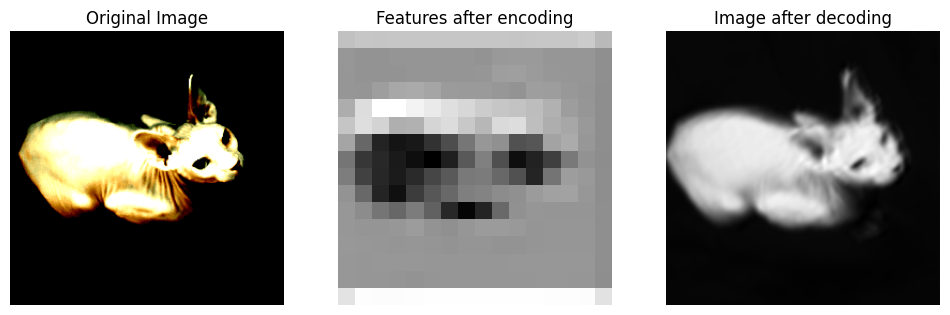

In [293]:
input_image = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Features after encoding")
plt.imshow(s4_1[0].squeeze(0).detach().numpy()[971], cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Image after decoding")
plt.imshow(output_imagenotrain[1], cmap='gray')
plt.axis("off")

plt.show()

In [291]:
import cv2

In [268]:
image_pathtrain = '/Users/haziq/Desktop/DIFFUSION_FROM_SCRATCH/Dataset/1 (1).jpg'
input_tensortrain = load_image(image_pathtrain, input_shape=(3, 256, 256))

In [269]:
with torch.no_grad():
    output, s4 = modelnotrain(input_tensortrain)

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 27, 128, 128])
Shape s2: torch.Size([1, 243, 64, 64])
Shape s3: torch.Size([1, 972, 32, 32])
Shape s4: torch.Size([1, 972, 16, 16])
Shape b1: torch.Size([1, 972, 14, 14])
Shape b2: torch.Size([1, 972, 12, 12])
Shape d1: torch.Size([1, 512, 20, 20])
Shape d2: torch.Size([1, 256, 36, 36])
Shape d3: torch.Size([1, 128, 68, 68])
Shape d4: torch.Size([1, 1, 132, 132])
Shape d5: torch.Size([1, 1, 260, 260])
Output Shape: torch.Size([1, 3, 260, 260])


In [270]:
output_image = output.squeeze(0).detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5005665].


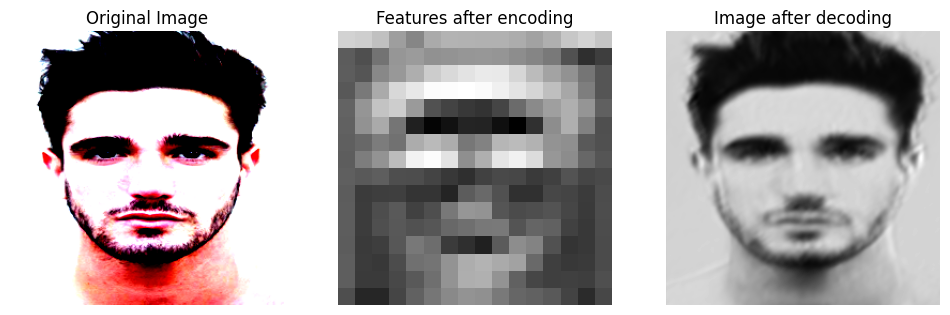

In [284]:
input_image = input_tensortrain.squeeze(0).cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Features after encoding")
plt.imshow(s4.squeeze(0).detach().numpy()[971], cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Image after decoding")
plt.imshow(output_image[2], cmap='gray')
plt.axis("off")

plt.show()

## Trying to train it maybe (?)

In [29]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms

In [30]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if f.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [73]:
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features[:16].eval()  # Use the first few layers of VGG
        for param in self.vgg.parameters():
            param.requires_grad = False  # Freeze the VGG parameters

    def forward(self, output, target):
        output_features = self.vgg(output)
        target_features = self.vgg(target)
        return nn.functional.mse_loss(output_features, target_features)

In [74]:
dataset_path = "/Users/haziq/Desktop/DIFFUSION_FROM_SCRATCH/Dataset"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageDataset(directory=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
model = KAN_UNET(input_shape=(3, 256, 256), num_classes=1, out_channels=3).to(device)
criterion = PerceptualLoss()#nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Training on cpu


In [79]:
epochs = 5  # Set number of epochs

In [80]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs = batch  # No labels, only images
        inputs = inputs.to(device)

        
        outputs, _ = model(inputs)

        
        loss = criterion(outputs, inputs)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")


Epoch 1/5:   0%|                                          | 0/1 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 9, 126, 126])
Shape s2: torch.Size([1, 27, 61, 61])
Shape s3: torch.Size([1, 81, 28, 28])
Shape s4: torch.Size([1, 243, 12, 12])
Shape b1: torch.Size([1, 243, 10, 10])
Shape b2: torch.Size([1, 243, 8, 8])
Shape d1: torch.Size([1, 256, 16, 16])
Shape d2: torch.Size([1, 128, 32, 32])
Shape d3: torch.Size([1, 64, 64, 64])
Shape d4: torch.Size([1, 1, 128, 128])
Shape d5: torch.Size([1, 1, 256, 256])
Output Shape: torch.Size([1, 3, 256, 256])


Epoch 1/5: 100%|██████████████████████████████████| 1/1 [01:35<00:00, 95.20s/it]


Epoch [1/5], Loss: 4.7724


Epoch 2/5:   0%|                                          | 0/1 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 9, 126, 126])
Shape s2: torch.Size([1, 27, 61, 61])
Shape s3: torch.Size([1, 81, 28, 28])
Shape s4: torch.Size([1, 243, 12, 12])
Shape b1: torch.Size([1, 243, 10, 10])
Shape b2: torch.Size([1, 243, 8, 8])
Shape d1: torch.Size([1, 256, 16, 16])
Shape d2: torch.Size([1, 128, 32, 32])
Shape d3: torch.Size([1, 64, 64, 64])
Shape d4: torch.Size([1, 1, 128, 128])
Shape d5: torch.Size([1, 1, 256, 256])
Output Shape: torch.Size([1, 3, 256, 256])


Epoch 2/5: 100%|██████████████████████████████████| 1/1 [01:30<00:00, 90.77s/it]


Epoch [2/5], Loss: 4.5752


Epoch 3/5:   0%|                                          | 0/1 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 9, 126, 126])
Shape s2: torch.Size([1, 27, 61, 61])
Shape s3: torch.Size([1, 81, 28, 28])
Shape s4: torch.Size([1, 243, 12, 12])
Shape b1: torch.Size([1, 243, 10, 10])
Shape b2: torch.Size([1, 243, 8, 8])
Shape d1: torch.Size([1, 256, 16, 16])
Shape d2: torch.Size([1, 128, 32, 32])
Shape d3: torch.Size([1, 64, 64, 64])
Shape d4: torch.Size([1, 1, 128, 128])
Shape d5: torch.Size([1, 1, 256, 256])
Output Shape: torch.Size([1, 3, 256, 256])


Epoch 3/5: 100%|██████████████████████████████████| 1/1 [01:20<00:00, 80.85s/it]


Epoch [3/5], Loss: 4.5517


Epoch 4/5:   0%|                                          | 0/1 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 9, 126, 126])
Shape s2: torch.Size([1, 27, 61, 61])
Shape s3: torch.Size([1, 81, 28, 28])
Shape s4: torch.Size([1, 243, 12, 12])
Shape b1: torch.Size([1, 243, 10, 10])
Shape b2: torch.Size([1, 243, 8, 8])
Shape d1: torch.Size([1, 256, 16, 16])
Shape d2: torch.Size([1, 128, 32, 32])
Shape d3: torch.Size([1, 64, 64, 64])
Shape d4: torch.Size([1, 1, 128, 128])
Shape d5: torch.Size([1, 1, 256, 256])
Output Shape: torch.Size([1, 3, 256, 256])


Epoch 4/5: 100%|██████████████████████████████████| 1/1 [01:24<00:00, 84.51s/it]


Epoch [4/5], Loss: 4.5046


Epoch 5/5:   0%|                                          | 0/1 [00:00<?, ?it/s]

Input Shape: torch.Size([1, 3, 256, 256])
Shape s1: torch.Size([1, 9, 126, 126])
Shape s2: torch.Size([1, 27, 61, 61])
Shape s3: torch.Size([1, 81, 28, 28])
Shape s4: torch.Size([1, 243, 12, 12])
Shape b1: torch.Size([1, 243, 10, 10])
Shape b2: torch.Size([1, 243, 8, 8])
Shape d1: torch.Size([1, 256, 16, 16])
Shape d2: torch.Size([1, 128, 32, 32])
Shape d3: torch.Size([1, 64, 64, 64])
Shape d4: torch.Size([1, 1, 128, 128])
Shape d5: torch.Size([1, 1, 256, 256])
Output Shape: torch.Size([1, 3, 256, 256])


Epoch 5/5: 100%|██████████████████████████████████| 1/1 [01:34<00:00, 94.77s/it]

Epoch [5/5], Loss: 1527.8082


# Comparing with traditional Variational Auto Encoder (work in progress)

## Decoder

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import math
# from attention import SelfAttention

In [ ]:
class SelfAttention(nn.Module):
    

In [ ]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        residue = x
        n, c, h, w = x.shape

        x = x.view(n, c, h * w)

        x = x.transpose(-1, -2)

        x = self.attention(x)

        x = x.transpose(-1, -2)

        x = x.view((n,c,h,w))

In [ ]:
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kerenl_size=1, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residue = x
        
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)

        x = self.groupnorm_2(x)
        x = F.silu(x)

        x = self.conv_2(x)
        
        return x + self.residual_layer(residue)

## Encoder

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

from decoder import VAE_AttentionBlock, VAE_Residualblock

In [ ]:
class VAE_Encoder(nn.Sequential):
    def __init__(self): 
        super().__init__(
            nn.Conv2d(3, 128, kernel_size=3, padding=1), #First convolutional layer, image size doesnt change cause of padding


            VAE_ResidualBlock(128,128), #Size still doesnt change
            nn.Conv2d(128,128, kernel_size=3, stride=2, padding=0), #Halves size
            VAE_ResidualBlock(128,256),
            VAE_ResidualBlock(256,256),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), #Halves again
            VAE_ResidualBlock(256,512),
            VAE_ResidualBlock(512,512),
            nn.Conv2d(512,512, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512,512),

            nn.GroupNorm(32, 512),
            nn.SiLU(),

            nn.Conv2d(512,8, kernel_size=3, padding=1),
            nn.Conv2d(8,8, kernel_size=1, padding=0)    
        )

    def forward(self, x:torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        for module in self:
            if getattr(module, 'stride', None) == (2,2):
                x = F.pad(x, (0, 1, 0, 1)) #Adds padding only to right and bottom of image

            x = module(x)
            
        mean, log_variance = torch.chunk(x, 2, dim=1)

        log_variance = torch.clamp(log_variance, -30, 20) #changes log value to a range if too small
        variance = log_variace.exp()
        stdev = variance.sqrt()

        x = mean + stdev * noise

        x *= 0.18215 #Dk why you multipy by this constant but stable diffusion model does